In [8]:
# simulaiton on porous structure, expected to see ....

In [9]:
from fenics import *
import numpy as np

# 1. hyper elastic material model, 2. applied forced 

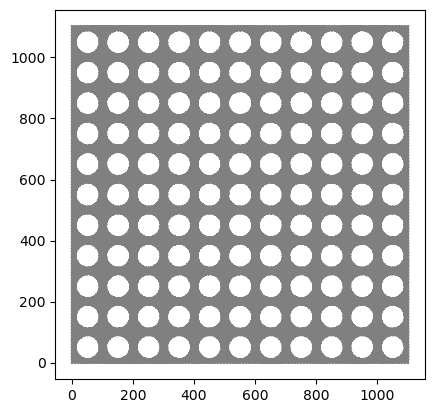

In [10]:
# path =
import os;
path = '/Users/1321143263qq.com/Dropbox/ScientificProject/1PaperProject/2023/Cassini_oval/results/fem_solutions/fenics_x_python/bistable_fem_test/'
mesh = Mesh(path + 'rve106.xml');
mesh = Mesh(path + 'rve109.xml');

coordinates = mesh.coordinates()
x_min, y_min = np.amin(coordinates, axis=0)[:2]
x_max, y_max = np.amax(coordinates, axis=0)[:2]
plot(mesh)
tol = 1.e-15;

# define the bouanry 
def top_bounary(x, on_boundary):
    return on_boundary and near(x[1], y_max)
def bottom_boundary(x, on_boundary):
    return on_boundary and near(x[1], y_min)
def left_boundary(x, on_boundary):
    return on_boundary and near(x[0], x_min)
def right_boundary(x, on_boundary):
    return on_boundary and near(x[0], x_max)

In [11]:

# traction on boundary
T = Constant((0.0, 0.0))
# body force
B = Constant((0.0, 0.0))

V = VectorFunctionSpace(mesh, "CG", 1)

# Define functions
du = TrialFunction(V)  # Incremental displacement
v = TestFunction(V)  # Test function
u = Function(V)  # Displacement from previous iteration
# Kinematics
d = u.geometric_dimension()
I = Identity(d)  # Identity tensor
F = I + grad(u)  
# --------------------
# Weak form
# --------------------
# Invariants of deformation tensors C
C = F.T * F
Ic = tr(C)
J = det(F)


# near imconpressible neo-Hookean model,come from 'mu_0', shear modulusm and 'K_0', bulk modulus
# cite: "Compaction Through Buckling in 2D Periodic, Soft and Porous Structures: Effect of Pore Shape"
E = 1.e6
nu = 0.4
mu,lmbda = Constant(E/(2*(1+nu))), Constant(E*nu/((1+nu)*(1-2*nu)))
psi = (mu / 2) * (Ic - 2) - mu * ln(J) + (lmbda / 2) * (ln(J))**2
psi = (mu / 2) * (Ic - 2) - mu * ln(J) + (lmbda / 2) * (ln(J))**2

# Total potential energy
Pi = psi*dx - dot(B, u)*dx - dot(T, u)*ds

# Compute first variation of Pi (directional derivative about u in the direction of v)
Forwd = derivative(Pi, u, v)
# Compute Jacobian of F
Jacobian = derivative(Forwd, u, du)



# function to meausre force and stress 

In [12]:


# FUNCTION:  meausre the force on the right boundary
def force_measure(u):
    F = Identity(2) + grad(u)
    E = 0.5 * (F.T * F - Identity(2))
    sigma = 2.0 * mu * E + lmbda * tr(E) * Identity(2)
    E = F.T * F # Green-Lagrange strain tensor
    J = det(F)
    Ic = tr(E);
    sigma = (mu / J) * (E - (1/J) * Ic * Identity(2)) + (lmbda / J) * ln(J) * Identity(2)
    boundary_markers = MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
    boundary_markers.set_all(0)  # Initialize with default value 0
    right_bndry = AutoSubDomain(lambda x, on_boundary: near(x[0], x_max) and on_boundary)
    right_bndry.mark(boundary_markers, 1)  # Mark the right boundary with value 1
    ds_right = Measure("ds", domain=mesh, subdomain_data=boundary_markers, subdomain_id=1)
    force = assemble(dot(sigma, FacetNormal(mesh))[0] * ds_right(1))
                           
    return force
def normal_stress_measure(u):
    F = Identity(2) + grad(u)
    E = 0.5 * (F.T * F - Identity(2))
    sigma = 2.0 * mu * E + lmbda * tr(E) * Identity(2)
    boundary_markers = MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
    boundary_markers.set_all(0)  # Initialize with default value 0
    right_bndry = AutoSubDomain(lambda x, on_boundary: near(x[0], x_max) and on_boundary)
    right_bndry.mark(boundary_markers, 1)  # Mark the right boundary with value 1
    ds_right = Measure("ds", domain=mesh, subdomain_data=boundary_markers, subdomain_id=1)
    normal_stress = dot(sigma, FacetNormal(mesh))  # Compute the dot product of sigma with the facet normal
    normal_stress_component = normal_stress[0]  # Extract the normal stress component in the x-direction
    # normal_stress_component = normal_stress[1]  # Extract the normal stress component in the y-direction    
    normal_stress_avg = assemble(normal_stress_component * ds_right(1)) / assemble(Constant(1.0) * ds_right(1))
    return normal_stress_avg



# ============================= solution =================================
parameters["form_compiler"]["cpp_optimize"] = True
ffc_options = {"optimize": True, \
               "eliminate_zeros": True, \
               "precompute_basis_const": True, \
               "precompute_ip_const": True}
deform_top_y = -0.1*(y_max-y_min);
bc_top = DirichletBC(V.sub(1), Expression("var", var=deform_top_y, degree=1), top_bounary)
bc_bottom = DirichletBC(V, Constant((0.0,0.0)), bottom_boundary)
# bc_bottom = DirichletBC(V.sub(1), Constant(0.), bottom_boundary)

bcs = [bc_bottom, bc_top];
problem = NonlinearVariationalProblem(Forwd, u, bcs, Jacobian, form_compiler_parameters=ffc_options)

solver = NonlinearVariationalSolver(problem)
# solver.parameters["newton_solver"]["linear_solver"] = "lu"    
# solver.parameters["newton_solver"]["linear_solver"] = "gmres"
solver.parameters["newton_solver"]["linear_solver"] = "mumps"

# solver.parameters["newton_solver"]["preconditioner"] = "ilu"
# solver.parameters["newton_solver"]["relative_tolerance"] = 1e-6


# Solve problem
solver.solve()

Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 3.146e+09 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 5.900e+06 (tol = 1.000e-10) r (rel) = 1.875e-03 (tol = 1.000e-09)
  Newton iteration 2: r (abs) = 6.486e+06 (tol = 1.000e-10) r (rel) = 2.061e-03 (tol = 1.000e-09)
  Newton iteration 3: r (abs) = 6.292e+06 (tol = 1.000e-10) r (rel) = 2.000e-03 (tol = 1.000e-09)
  Newton iteration 4: r (abs) = 3.248e+06 (tol = 1.000e-10) r (rel) = 1.032e-03 (tol = 1.000e-09)
  Newton iteration 5: r (abs) = 1.732e+08 (tol = 1.000e-10) r (rel) = 5.504e-02 (tol = 1.000e-09)
  Newton iteration 6: r (abs) = nan (tol = 1.000e-10) r (rel) = nan (tol = 1.000e-09)
  Newton iteration 7: r (abs) = nan (tol = 1.000e-10) r (rel) = nan (tol = 1.000e-09)
  Newton iteration 8: r (abs) = nan (tol = 1.000e-10) r (rel) = nan (tol = 1.000e-09)
  Newton iteration 9: r (abs) = nan (tol = 1.000e-10) r (rel) = nan (tol = 1.000e-09)
  Newton iteration 10: r (abs

RuntimeError: 

*** -------------------------------------------------------------------------
*** DOLFIN encountered an error. If you are not able to resolve this issue
*** using the information listed below, you can ask for help at
***
***     fenics-support@googlegroups.com
***
*** Remember to include the error message listed below and, if possible,
*** include a *minimal* running example to reproduce the error.
***
*** -------------------------------------------------------------------------
*** Error:   Unable to solve nonlinear system with NewtonSolver.
*** Reason:  Newton solver did not converge because maximum number of iterations reached.
*** Where:   This error was encountered inside NewtonSolver.cpp.
*** Process: 0
*** 
*** DOLFIN version: 2019.1.0
*** Git changeset:  
*** -------------------------------------------------------------------------


# Increment solutuon    


In [ ]:
# ============================= post-processing =================================
import matplotlib.pyplot as plt
plot(u, mode="displacement")
# plot deformed mesh
mesh_deformed = Mesh(mesh)
ALE.move(mesh_deformed, u)

# Plot the deformed mesh
plot(mesh,alpha= 0.5)

# Show the plot
plt.show()







In [ ]:
plot(mesh_deformed)